In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as ctb
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [2]:
train_set = pd.read_csv('train_prepared.csv', encoding='utf-8')
test_set = pd.read_csv('test_prepared.csv', encoding='utf-8')

train_set = train_set.replace([np.inf,-np.inf], np.nan)
test_set = test_set.replace([np.inf,-np.inf], np.nan)

In [3]:
train_set.head()

,Opportunity_ID,Target,Convertibility,Total_Amount_Sum_USD,Total_Taxable_Amount_USD,Year_Creation,Month_Creation,Year_Delivery,Month_Delivery,Days_Passed,...,Delivery_Terms_target,Bureaucratic_Code_target,Opportunity_Type_target,Source _target,Region_target,Or,Expiry_Days_Create,Expiry_Days_Modified,Days_Modified_Diff_to_Start_Delivery,Days_Modified_Diff_to_End_Delivery
0,0,0,1.131096,5964043.80,5964043.80,2015,12,2016,5,189.0,...,0.479354,0.593111,0.517054,0.509776,0.462820,0,54.0,-135.0,43.0,-17.0
1,1,1,1.131094,54552.68,54552.68,2015,12,2016,1,39.0,...,0.479354,0.593111,0.517054,0.509776,0.462820,0,44.0,5.0,-3.0,-5.0
2,2,1,1.000000,83865.60,83865.60,2015,12,2016,1,296.0,...,0.543384,0.593111,0.517054,0.438859,0.444896,0,297.0,1.0,248.0,248.0
3,3,0,1.000000,7421881.50,7421881.50,2015,12,2018,2,840.0,...,0.445609,0.266444,0.156954,0.632822,0.444896,1,NaN,NaN,54.0,-4.0
4,4,0,1.000000,13357192.50,13357192.50,2015,12,2018,2,840.0,...,0.445609,0.266444,0.156954,0.632822,0.444896,1,542.0,-298.0,54.0,27.0


In [4]:
X = train_set.drop(columns=['Target', 'Opportunity_ID'])
y = train_set.Target

In [5]:
X.columns

Index(['Convertibility', 'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD',
       'Year_Creation', 'Month_Creation', 'Year_Delivery', 'Month_Delivery',
       'Days_Passed', 'Wait_Time_Days', 'Delivery_Window',
       'Account_LifeSpan_at_Creation', 'Account_LifeSpan_at_Modif',
       'Account_LifeSpan_at_Deliv', 'Wait_Delivery_Cmp', 'Days_Left_Cmp',
       'Days_Wait_Cmp', 'USD_Per_Day_Waited', 'USD_Per_Day_Passed',
       'USD_Per_Account_Day', 'Product_Price_Mean', 'Product_Price_Max',
       'Product_Price_Std', 'Product_Price_Min', 'Total_TRF',
       'Territory_target', 'Billing_Country_target', 'Delivery_Terms_target',
       'Bureaucratic_Code_target', 'Opportunity_Type_target', 'Source _target',
       'Region_target', 'Or', 'Expiry_Days_Create', 'Expiry_Days_Modified',
       'Days_Modified_Diff_to_Start_Delivery',
       'Days_Modified_Diff_to_End_Delivery'],
      dtype='object')

In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer


numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer()),
                            ('scaler', KBinsDiscretizer(n_bins=5, strategy='quantile'))
                        ]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                        ],
                    remainder='passthrough'
                    )

In [8]:
# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
best = {'learning_rate': 0.01,
 'l2_leaf_reg': 2.45,
 'iterations': 500,
 'depth': 5,
 'border_count': 200}

cat = ctb.CatBoostClassifier(silent=True, **best)

pipe = Pipeline([('preprocessing', preprocessor),('rf',cat)])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = pipe.fit(X=X_train, y=y_train)

C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 11 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in featur

In [9]:
log_loss(y_test, pipe.predict_proba(X_test))

0.3728541581812173

In [10]:
log_loss(test_set.Target, pipe.predict_proba(test_set.drop(columns=['Opportunity_ID'])))

0.42876897941228653

# CatBoost solo

In [11]:
best = {'learning_rate': 0.01,
 'l2_leaf_reg': 2.45,
 'iterations': 500,
 'depth': 5,
 'border_count': 200}

cat = ctb.CatBoostClassifier(silent=True, **best)

cat.fit(X_train, y_train)

In [12]:
log_loss(y_test, cat.predict_proba(X_test))

0.35677369925200614

In [13]:
log_loss(test_set.Target, cat.predict_proba(test_set.drop(columns=['Opportunity_ID'])))

0.4497721251160139

# Guardado de la prediccion

In [14]:
final = test_set.loc[:, ['Opportunity_ID', 'Target']].copy()
final['Target'] = pd.DataFrame(pipe.predict_proba(test_set.drop(columns=['Opportunity_ID', 'Target']))[:, 1])
final.to_csv('predictions/cat.csv', index=False)

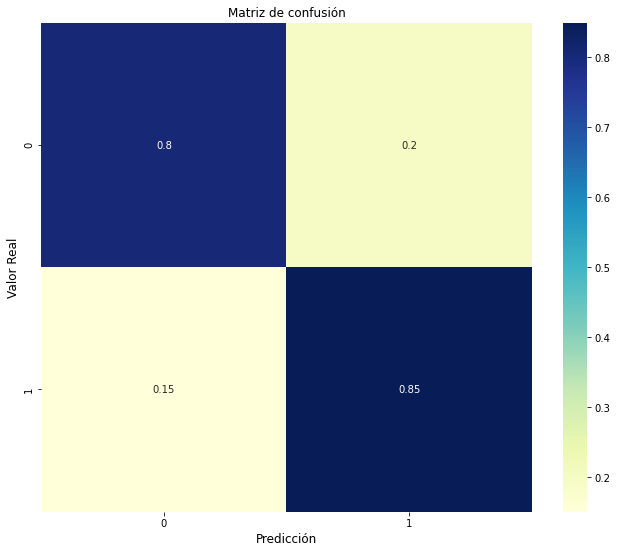

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))
plt.title('Matriz de confusión')
sns.heatmap(confusion_matrix(y_pred=pipe.predict(X_test), y_true=y_test, normalize='true'), cmap='YlGnBu', annot=True)
ax.set_xlabel('Predicción', fontsize = 12)
plt.ylabel('Valor Real', fontsize = 12)
plt.show()